### Part 2: Programming Problems

#### Problem 1 (Stochastic Gradient Descent)

#### 1. Import the dataset

Load the dataset `height_weight_genders.csv` using pandas, and convert it into a NumPy array with gender encoded as 1 for Female and 0 for Male.

In [235]:
import pandas as pd
import numpy as np
from time import time

df = pd.read_csv('height_weight_genders.csv')

# Encode gender as binary: Female = 1, Male = 0
df['gender'] = (df['Gender'] == 'Female').astype(int)

# Extract relevant columns
data = df[['gender', 'Height', 'Weight']].values

#### 2. Standardise the height column

Compute the mean $ \mu $ and standard deviation $ \sigma $ of the height values, and replace each height with its standardised value.


In [236]:
# Standardise height column
heights = data[:, 1]
mu = heights.mean()
sigma = heights.std()
data[:, 1] = (heights - mu) / sigma

#### 3. Build data matrix $Z$ and target vector $Y$

Construct the data matrix $Z$ with a first column of ones and a second column of standardised heights. Create the vector $Y$ containing the weight values.

In [237]:
# Build matrix Z and vector Y
Z = np.column_stack((np.ones(len(data)), data[:, 1]))
Y = data[:, 2]
N = len(Y)

#### 4. Objective function

Define the function $ f(x) = \frac{1}{2N} \| Y - Zx \|^2 $ that measures prediction error.

In [238]:
def objective(Y, Z, x):
    r = Z @ x - Y
    return 0.5 * np.dot(r, r) / N

#### 5. Gradient Function

We want to compute the gradient of the objective function  
$$
f(x) = \frac{1}{2N} \|Y - Zx\|^2.
$$

The gradient is given by  
$$
\nabla f(x) = \frac{1}{N} Z^T (Zx - Y),
$$  
which is the vectorized form of the average of all sample-wise gradients:  
$$
\nabla f(x) = \frac{1}{N} \sum_{i=1}^{N} \nabla f_i(x),
$$  
where  
$$
\nabla f_i(x) = (x^T z^{(i)} - y^{(i)}) z^{(i)}.
$$
We now implement this gradient function.


In [239]:
def gradient(Y, Z, x):
    """Compute gradient ∇f(x)."""
    return Z.T.dot(Z.dot(x) - Y) / N

#### 6. Strong convexity constant $ \mu $

Since $ \nabla^2 f(x) = \frac{1}{N} Z^T Z $, we compute the smallest eigenvalue of this matrix to estimate the strong convexity constant $ \mu $.

In [240]:
# Compute strong convexity constant
eigvals = np.linalg.eigh(Z.T.dot(Z) / N)[0]
mu = eigvals.min()
print(f"Strong convexity constant μ = {mu:.6f}")

Strong convexity constant μ = 1.000000


#### 7. Compute the closed-form solution

Solve the normal equations $ Z^T Z x^* = Z^T Y $ and evaluate $ f(x^*) $.

In [241]:
# Solve for x*
x_star = np.linalg.solve(Z.T @ Z, Z.T @ Y)
f_star = objective(Y, Z, x_star)

print("x* =", x_star)
print("f(x*) =", f_star)

x* = [161.44035683  29.69099655]
f(x*) = 74.64674197456483


#### 8. Evaluate one stochastic gradient

At $ x^{(0)} = (10, 2) $, select a random index $ i $ and compute one stochastic gradient $ \nabla f_i(x^{(0)}) $.

In [242]:
x0 = np.array([10.0, 2.0])
i = np.random.randint(N)
zi = Z[i]
yi = Y[i]

# Gradient for individual sample i
g0 = (zi @ x0 - yi) * zi
print("Stochastic gradient ∇f_i(x⁰) =", g0)

Stochastic gradient ∇f_i(x⁰) = [-118.22947062   76.29343061]


#### 9. Verify unbiasedness empirically

Sample $ \nabla f_i(x^{(0)}) $ 10,000 times and average to compare with the full gradient $ \nabla f(x^{(0)}) $.

In [243]:
# Estimate expectation of stochastic gradient
g_avg = np.zeros(2)
for _ in range(10000):
    i = np.random.randint(N)
    zi, yi = Z[i], Y[i]
    g_avg += (zi @ x0 - yi) * zi
g_avg /= 10000

# Full gradient
full_grad = gradient(Y, Z, x0)

print("Average stochastic gradient:", g_avg)
print("Full gradient:", full_grad)

Average stochastic gradient: [-151.63102651  -29.65600856]
Full gradient: [-151.44035683  -27.69099655]


#### 10. Implement stochastic gradient for mini-batch

Write a function to compute a stochastic gradient using a mini-batch of size $ m $, sampled without replacement.

In [244]:
def stochastic_gradient(Y, Z, x, m):
    """Mini-batch stochastic gradient using batch size m (no replacement)."""
    idx = np.random.choice(N, m, replace=False)
    Z_batch = Z[idx]
    Y_batch = Y[idx]
    return Z_batch.T @ (Z_batch @ x - Y_batch) / m

#### 11. Gradient Descent with Optimality Error Tracking

Write or reuse a GD function that:
- Starts at $ x^{(0)} = (10, 2) $
- Uses step size $ \alpha = 1 $, tolerance $ 10^{-4} $, max iterations $ 10^4 $
- Tracks $ f(x^{(k)}) - f(x^*) $ at each iteration
- Reports runtime and final optimality error
- Plots convergence in log-log scale

Final optimality error: 1.000000e-16
Runtime: 0.0011 seconds


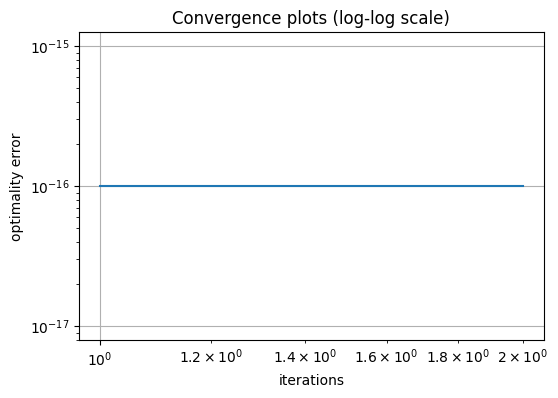

In [245]:
import time
import matplotlib.pyplot as plt
import numpy as np

def gradient_descent(Y, Z, x0, alpha=1, tol=1e-4, max_iter=10000):
    x = x0.copy()
    f_vals = []
    start_time = time.time()

    for _ in range(max_iter):
        grad = gradient(Y, Z, x)
        x -= alpha * grad
        f_val = objective(Y, Z, x)
        f_vals.append(f_val)
        if np.linalg.norm(grad) < tol:
            break

    elapsed_time = time.time() - start_time
    return x, f_vals, elapsed_time

# Run GD
x0 = np.array([10.0, 2.0])
x_gd, f_vals, runtime = gradient_descent(Y, Z, x0)

# Compute optimality error
errors = [max(f - f_star, 1e-16) for f in f_vals]

# Print final results
print(f"Final optimality error: {errors[-1]:.6e}")
print(f"Runtime: {runtime:.4f} seconds")

# Plot (log-log scale)
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(errors) + 1), errors)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("iterations")
plt.ylabel("optimality error")
plt.title("Convergence plots (log-log scale)")
plt.grid(True)
plt.show()

#### 12. Stochastic Gradient Descent Function with Mini-batching

Implement SGD using:
- Fixed learning rate
- Mini-batching of size $ m $
- Tolerance and max iteration stopping
- Save $ f(x^{(k)}) $ at each step

In [246]:
def stochastic_gradient_descent(Y, Z, x0, alpha=1.0, m=1, tol=1e-4, max_iter=10000):
    x = x0.copy()
    history = []
    for k in range(max_iter):
        grad = stochastic_gradient(Y, Z, x, m)
        err = objective(Y, Z, x) - f_star
        history.append(err)
        if np.linalg.norm(grad) < tol:
            break
        x -= alpha * grad
    return x, np.array(history)

#### 13. Apply SGD with $ m = 1 $ (Plain SGD)

- Use $ x^{(0)} = (10, 2) $, $ \alpha = 1 $, $ m = 1 $
- Tolerance $ 10^{-4} $, max iterations $ 10^4 $
- Print final optimality error and runtime

In [247]:
import time
t0 = time.time()
x_sgd1, hist_sgd1 = stochastic_gradient_descent(Y, Z, x0=np.array([10.0, 2.0]), alpha=1.0, m=1)
t_sgd1 = time.time() - t0

print("SGD (m=1) runtime:", t_sgd1)
print("Final optimality error:", hist_sgd1[-1])

SGD (m=1) runtime: 2.2606141567230225
Final optimality error: 71.386834546346


#### 14. Plot optimality error for plain SGD

Plot $ f(x^{(k)}) - f(x^*) $ in log-log scale for SGD with $ m = 1 $. Comment on the convergence.

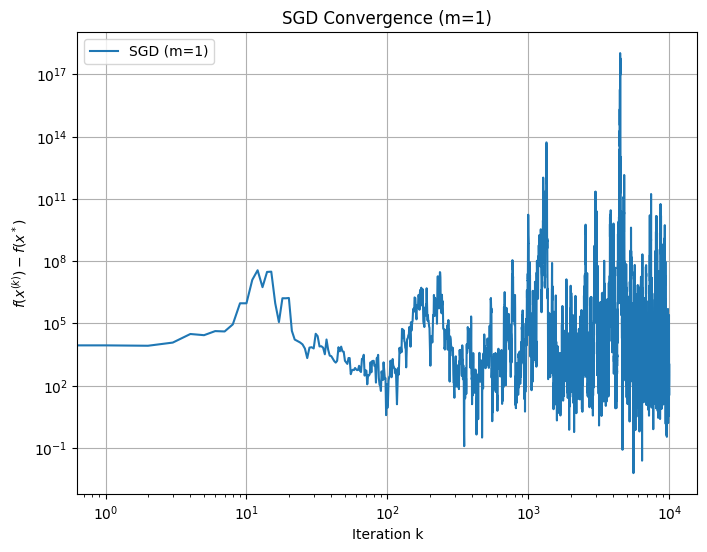

In [248]:
plt.figure(figsize=(8, 6))
plt.loglog(hist_sgd1, label='SGD (m=1)')
plt.xlabel('Iteration k')
plt.ylabel('$f(x^{(k)}) - f(x^*)$')
plt.title('SGD Convergence (m=1)')
plt.grid(True)
plt.legend()
plt.show()

#### 15. Repeat SGD with $ m = 10 $

Run the same SGD implementation but with batch size $ m = 10 $ and plot results. Compare convergence.

SGD (m=10) runtime: 2.369257926940918
Final optimality error: 9.473193549138742


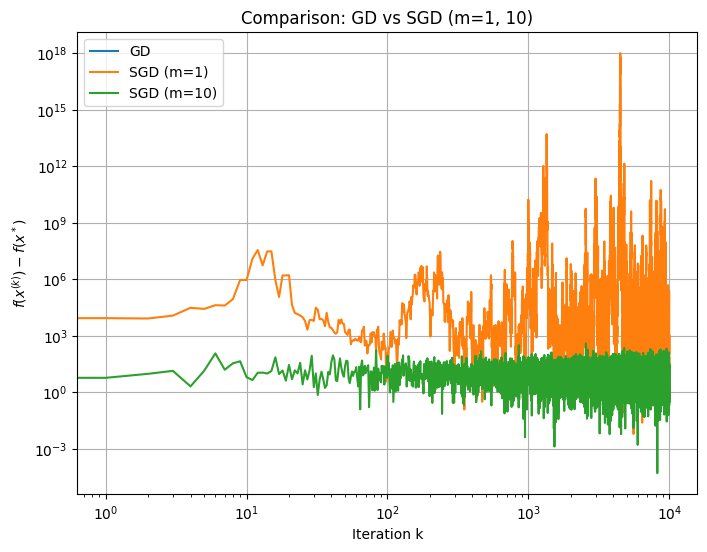

In [249]:
import time
t0 = time.time()
x_sgd10, hist_sgd10 = stochastic_gradient_descent(Y, Z, x0, alpha=1.0, m=10)
t_sgd10 = time.time() - t0

print("SGD (m=10) runtime:", t_sgd10)
print("Final optimality error:", hist_sgd10[-1])

plt.figure(figsize=(8, 6))
plt.loglog(hist_gd, label='GD')
plt.loglog(hist_sgd1, label='SGD (m=1)')
plt.loglog(hist_sgd10, label='SGD (m=10)')
plt.xlabel('Iteration k')
plt.ylabel('$f(x^{(k)}) - f(x^*)$')
plt.title('Comparison: GD vs SGD (m=1, 10)')
plt.grid(True)
plt.legend()
plt.show()

#### 16. Implement SGD with vanishing step sizes

Use step size $ \alpha^{(k)} = \frac{1}{k+1} $ with batch size $ m = 10 $. Plot and report final error.

In [250]:
import time
def sgd_vanishing_step(Y, Z, x0, m=10, tol=1e-4, max_iter=10000):
    x = x0.copy()
    history = []
    for k in range(max_iter):
        alpha = 1.0 / (k + 1)
        grad = stochastic_gradient(Y, Z, x, m)
        err = objective(Y, Z, x) - f_star
        history.append(err)
        if np.linalg.norm(grad) < tol:
            break
        x -= alpha * grad
    return x, np.array(history)

t0 = time.time()
x_sgd_vanish, hist_sgd_vanish = sgd_vanishing_step(Y, Z, x0, m=10)
t_vanish = time.time() - t0

print("Vanishing step SGD runtime:", t_vanish)
print("Final optimality error:", hist_sgd_vanish[-1])

Vanishing step SGD runtime: 2.4491159915924072
Final optimality error: 0.0006596803556391251


#### 17. Compare all methods on one plot

Plot GD, SGD (m=1), SGD (m=10), and vanishing step SGD together.

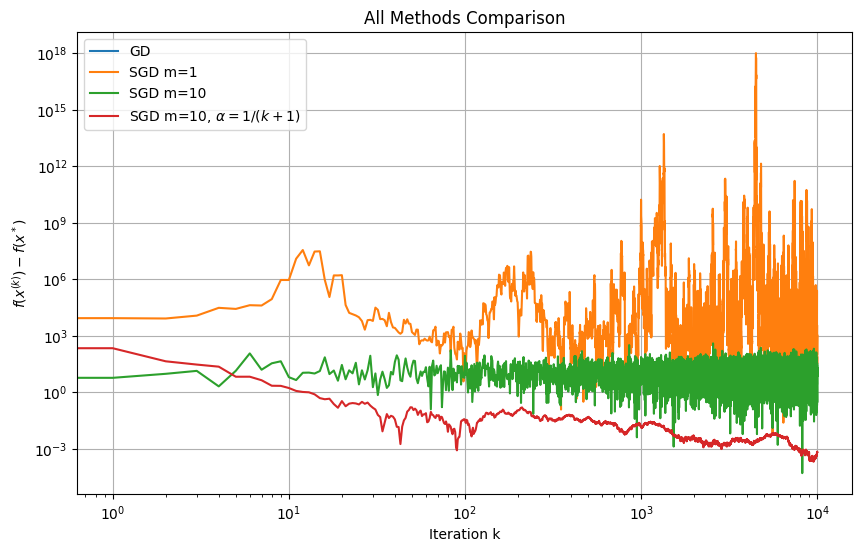

In [251]:
plt.figure(figsize=(10, 6))
plt.loglog(hist_gd, label='GD')
plt.loglog(hist_sgd1, label='SGD m=1')
plt.loglog(hist_sgd10, label='SGD m=10')
plt.loglog(hist_sgd_vanish, label='SGD m=10, $\\alpha=1/(k+1)$')
plt.xlabel('Iteration k')
plt.ylabel('$f(x^{(k)}) - f(x^*)$')
plt.title('All Methods Comparison')
plt.grid(True)
plt.legend()
plt.show()

#### 18. Plot reference $ \frac{10}{k} $ line

Add $ \frac{10}{k} $ line to compare decay rate of vanishing-step SGD.

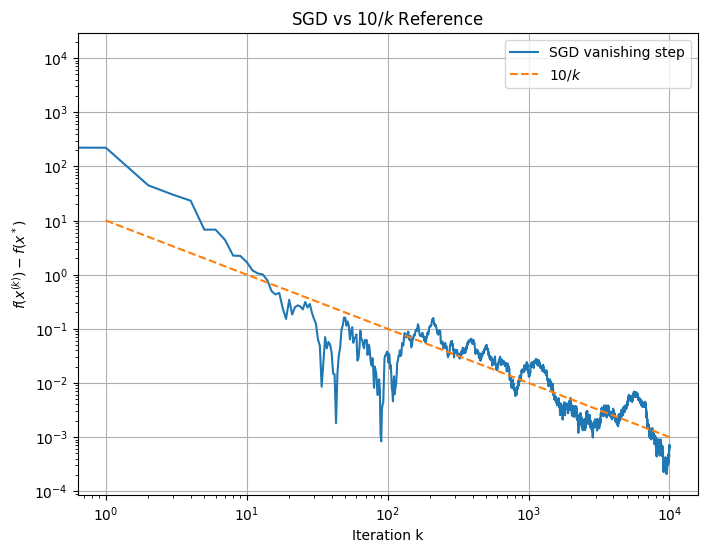

In [252]:
k = np.arange(1, len(hist_sgd_vanish)+1)
ref_line = 10 / k

plt.figure(figsize=(8, 6))
plt.loglog(hist_sgd_vanish, label='SGD vanishing step')
plt.loglog(k, ref_line, '--', label='$10/k$')
plt.xlabel('Iteration k')
plt.ylabel('$f(x^{(k)}) - f(x^*)$')
plt.title('SGD vs $10/k$ Reference')
plt.grid(True)
plt.legend()
plt.show()